In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd
import random
import math

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,8)

# Estadísticos
# ------------------------------------------------------------------------------
from scipy import stats
import researchpy as rp
from scipy.stats import levene
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm


# Para la gestión de los warning
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')




### ASUNCIONES

In [2]:
df= pd.read_pickle("../data/outliers_gestion.pkl")
df.head(2)

,fecha,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo,sensacion_termica,humedad,velocidad_viento,alquiler_casual,alquiler_registrado,total_alquileres
0,2018-01-01,Invierno,2018,enero,no_festivo,lunes,0,2,18.18125,80.5833,10.749882,331,654,985
1,2018-01-02,Invierno,2018,enero,no_festivo,martes,0,2,17.68695,69.6087,16.652113,131,670,801


Vamos comprobar la normalidad de nuestras variables respuestas para los dos modelos.

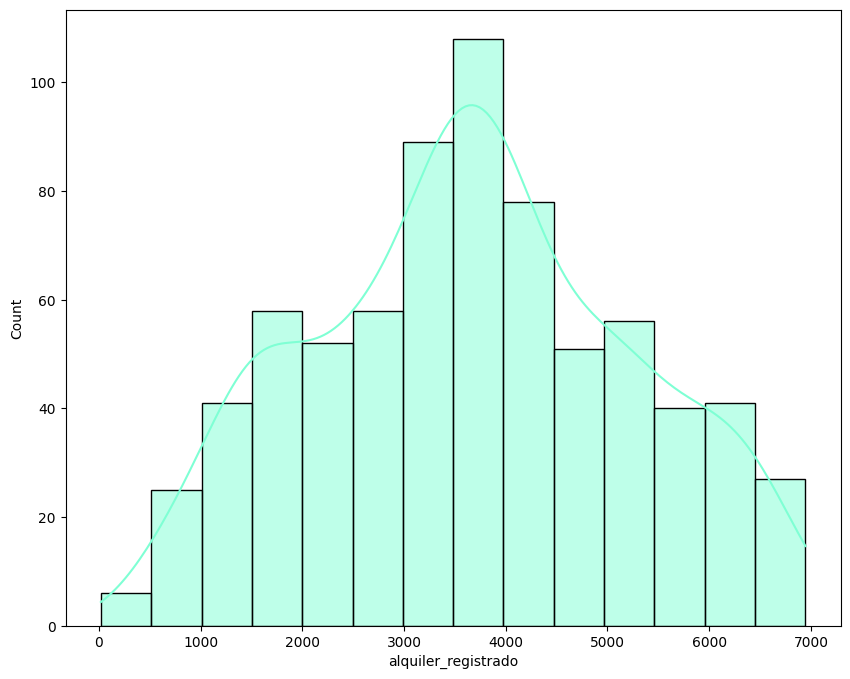

In [3]:
#Variable respuesta modelo II: 'alquiler_registrado'

sns.histplot(df["alquiler_registrado"], kde = True, color = "aquamarine");

In [4]:
stats.shapiro(df["alquiler_registrado"])

ShapiroResult(statistic=0.9843854308128357, pvalue=5.023125027037167e-07)

Raíz-cuadrada porque tenemos sesgo a la derecha

In [5]:
#Probamos de normalizar 'alquiler_registrado' con la raiz cuadrada, ya que está muy sesgada a la izquierda

df["alquiler_registrado_raiz"] = df["alquiler_registrado"].apply(lambda x: math.sqrt(x))
df.head(2)

,fecha,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo,sensacion_termica,humedad,velocidad_viento,alquiler_casual,alquiler_registrado,total_alquileres,alquiler_registrado_raiz
0,2018-01-01,Invierno,2018,enero,no_festivo,lunes,0,2,18.18125,80.5833,10.749882,331,654,985,25.573424
1,2018-01-02,Invierno,2018,enero,no_festivo,martes,0,2,17.68695,69.6087,16.652113,131,670,801,25.884358


In [6]:
#comprobamos con el shapiro si se han normalizado los datos 

stats.shapiro(df["alquiler_registrado_raiz"])

ShapiroResult(statistic=0.9734112620353699, pvalue=2.976442425861592e-10)

In [7]:
#probamos a normalizar la variable con box-cox

df['alquiler_registrado_boxcox'], lambda_ajustada = stats.boxcox(df['alquiler_registrado'])
df.head(2)

,fecha,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo,sensacion_termica,humedad,velocidad_viento,alquiler_casual,alquiler_registrado,total_alquileres,alquiler_registrado_raiz,alquiler_registrado_boxcox
0,2018-01-01,Invierno,2018,enero,no_festivo,lunes,0,2,18.18125,80.5833,10.749882,331,654,985,25.573424,267.555885
1,2018-01-02,Invierno,2018,enero,no_festivo,martes,0,2,17.68695,69.6087,16.652113,131,670,801,25.884358,273.035135


In [8]:
stats.shapiro(df["alquiler_registrado_boxcox"])

ShapiroResult(statistic=0.9854223132133484, pvalue=1.163151068794832e-06)

Podemos visualizar la diferencia entre los datos normalizados y sin normalizar con un distplot

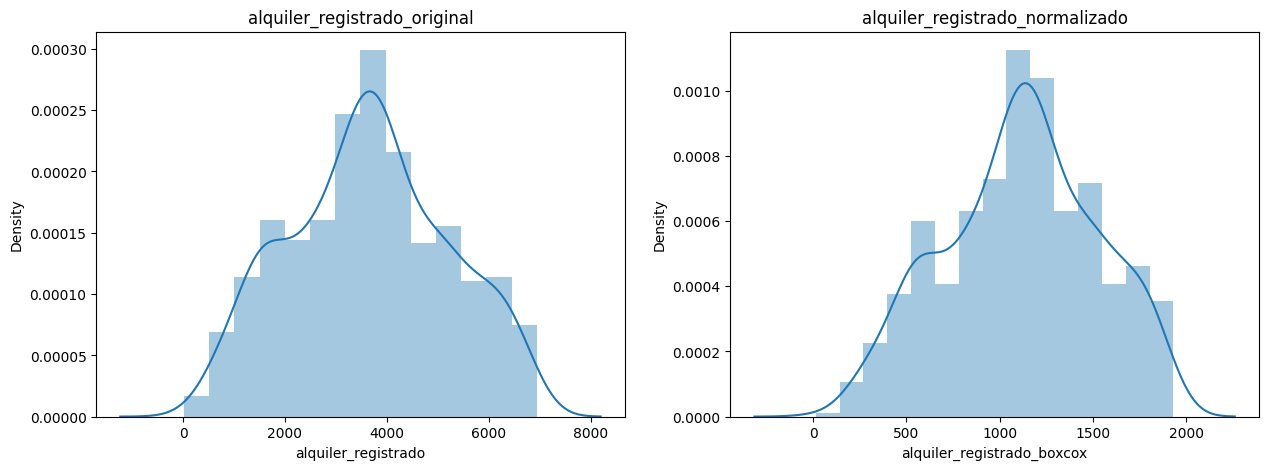

In [9]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))
axes[0].set_title('alquiler_registrado_original')
axes[1].set_title('alquiler_registrado_normalizado')
sns.distplot(df["alquiler_registrado"] ,ax = axes[0])
sns.distplot(df["alquiler_registrado_boxcox"], ax = axes[1]);

In [10]:
#Nos quedamos con la columna 'alquiler_casual_boxcox'

df.drop(['alquiler_registrado', 'alquiler_registrado_raiz'], axis = 1, inplace = True)
df.head()

,fecha,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo,sensacion_termica,humedad,velocidad_viento,alquiler_casual,total_alquileres,alquiler_registrado_boxcox
0,2018-01-01,Invierno,2018,enero,no_festivo,lunes,0,2,18.18125,80.5833,10.749882,331,985,267.555885
1,2018-01-02,Invierno,2018,enero,no_festivo,martes,0,2,17.68695,69.6087,16.652113,131,801,273.035135
2,2018-01-03,Invierno,2018,enero,no_festivo,miercoles,1,1,9.47025,43.7273,16.636703,120,1349,453.922956
3,2018-01-04,Invierno,2018,enero,no_festivo,jueves,1,1,10.60610,59.0435,10.739832,108,1562,522.514924
4,2018-01-05,Invierno,2018,enero,no_festivo,viernes,1,1,11.46350,43.6957,12.522300,82,1600,541.694947


Con el box-cox los datos se han corregido bastante, pero siguen sin estar normalizados.

Con esta variable decidimos pasar directamente a un Decision Tree

In [11]:
#Lo primero que hacemos es estandarizar las variables numéricas

df_num = df.select_dtypes(include = np.number)


In [12]:
df_num.head(2)

,sensacion_termica,humedad,velocidad_viento,alquiler_casual,total_alquileres,alquiler_registrado_boxcox
0,18.18125,80.5833,10.749882,331,985,267.555885
1,17.68695,69.6087,16.652113,131,801,273.035135


In [13]:
#Iniciamos el método RobustScaler y lo aplicamos
robust = RobustScaler()
robust.fit(df_num)
X_robust = robust.transform(df_num)

In [14]:
numericas_robust = pd.DataFrame(X_robust, columns = df_num.columns)
numericas_robust.head(2)

,sensacion_termica,humedad,velocidad_viento,alquiler_casual,total_alquileres,alquiler_registrado_boxcox
0,-0.456399,0.856714,-0.208909,-0.494713,-1.274385,-1.461478
1,-0.492863,0.332554,0.687550,-0.751041,-1.340188,-1.452214


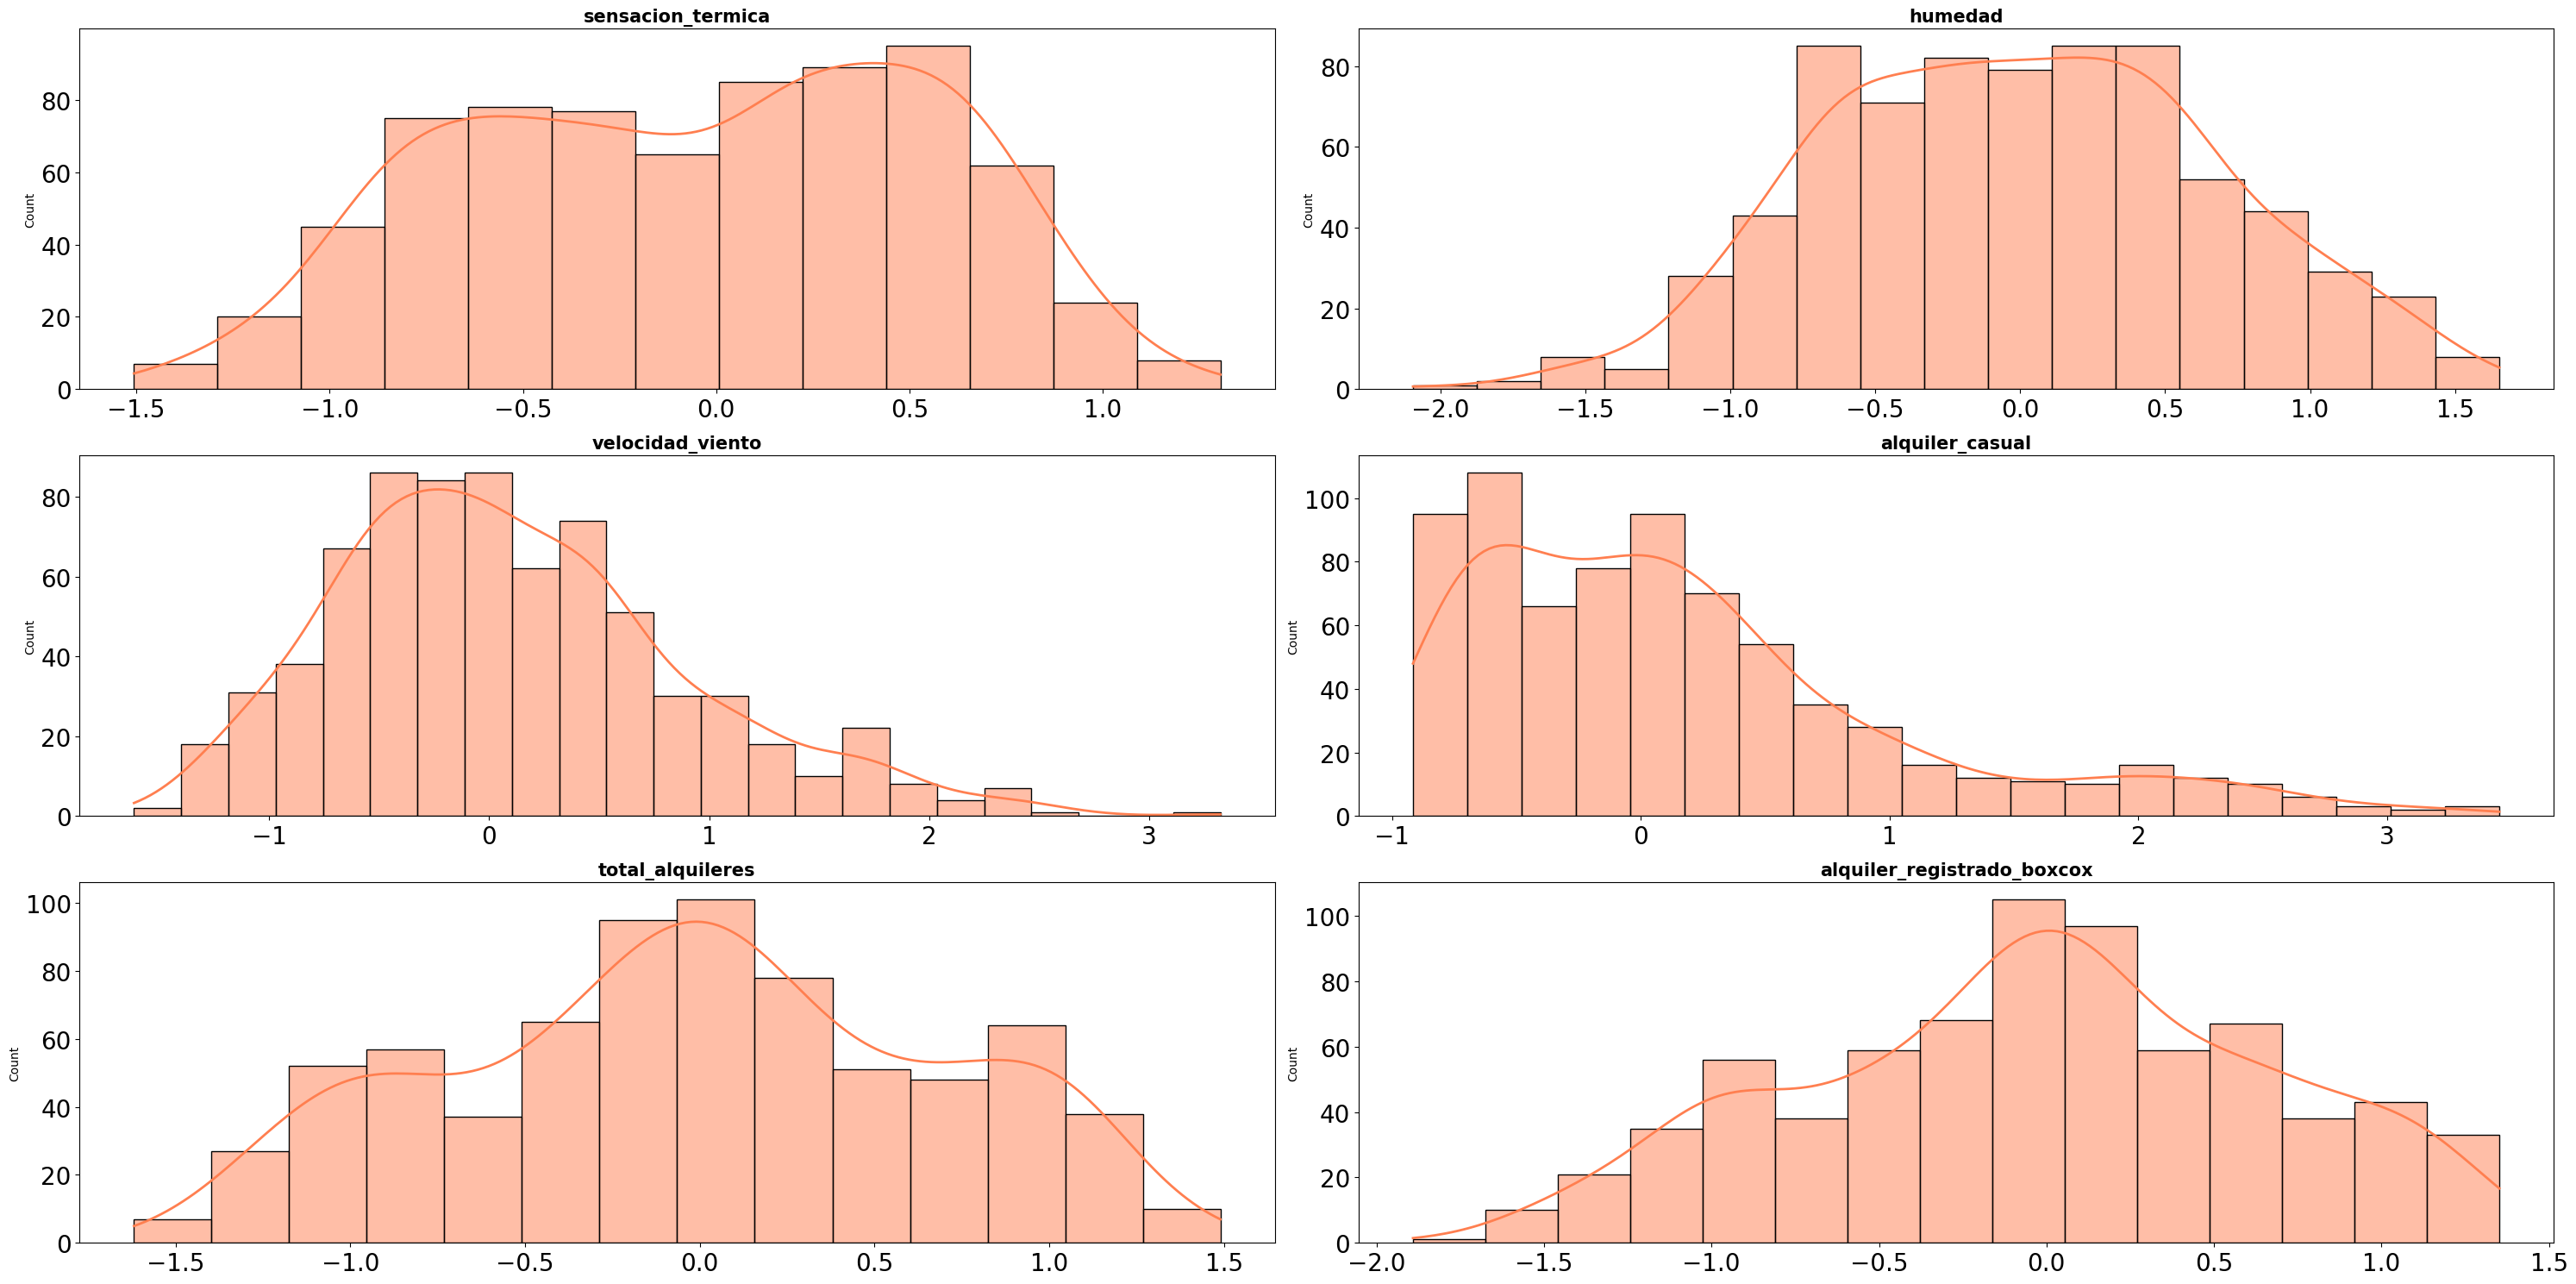

In [15]:
#Visualizamos la distribución de las variables numéricas una vez estandarizadas

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (30, 15))
columnas_robust = numericas_robust.columns
axes = axes.flat

for i, colum in enumerate(columnas_robust):
    sns.histplot(
        data = numericas_robust,
        x = colum,
        color= "coral",
        kde = True,
        line_kws = {"linewidth": 2},
        ax = axes[i])
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    
fig.tight_layout();

In [16]:
#Adjuntamos las variables estandarizadas a nuestro dataframe

df_est = df_num[df_num.columns] = numericas_robust
df_est.head(2)


,sensacion_termica,humedad,velocidad_viento,alquiler_casual,total_alquileres,alquiler_registrado_boxcox
0,-0.456399,0.856714,-0.208909,-0.494713,-1.274385,-1.461478
1,-0.492863,0.332554,0.687550,-0.751041,-1.340188,-1.452214


Codificamos las variables categóricas

In [17]:
#Creamos un dataframe sólo con las variables categóricas

df_cat = df.select_dtypes(exclude=np.number).drop('fecha', axis = 1)
df_cat.head(2)

,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo
0,Invierno,2018,enero,no_festivo,lunes,0,2
1,Invierno,2018,enero,no_festivo,martes,0,2


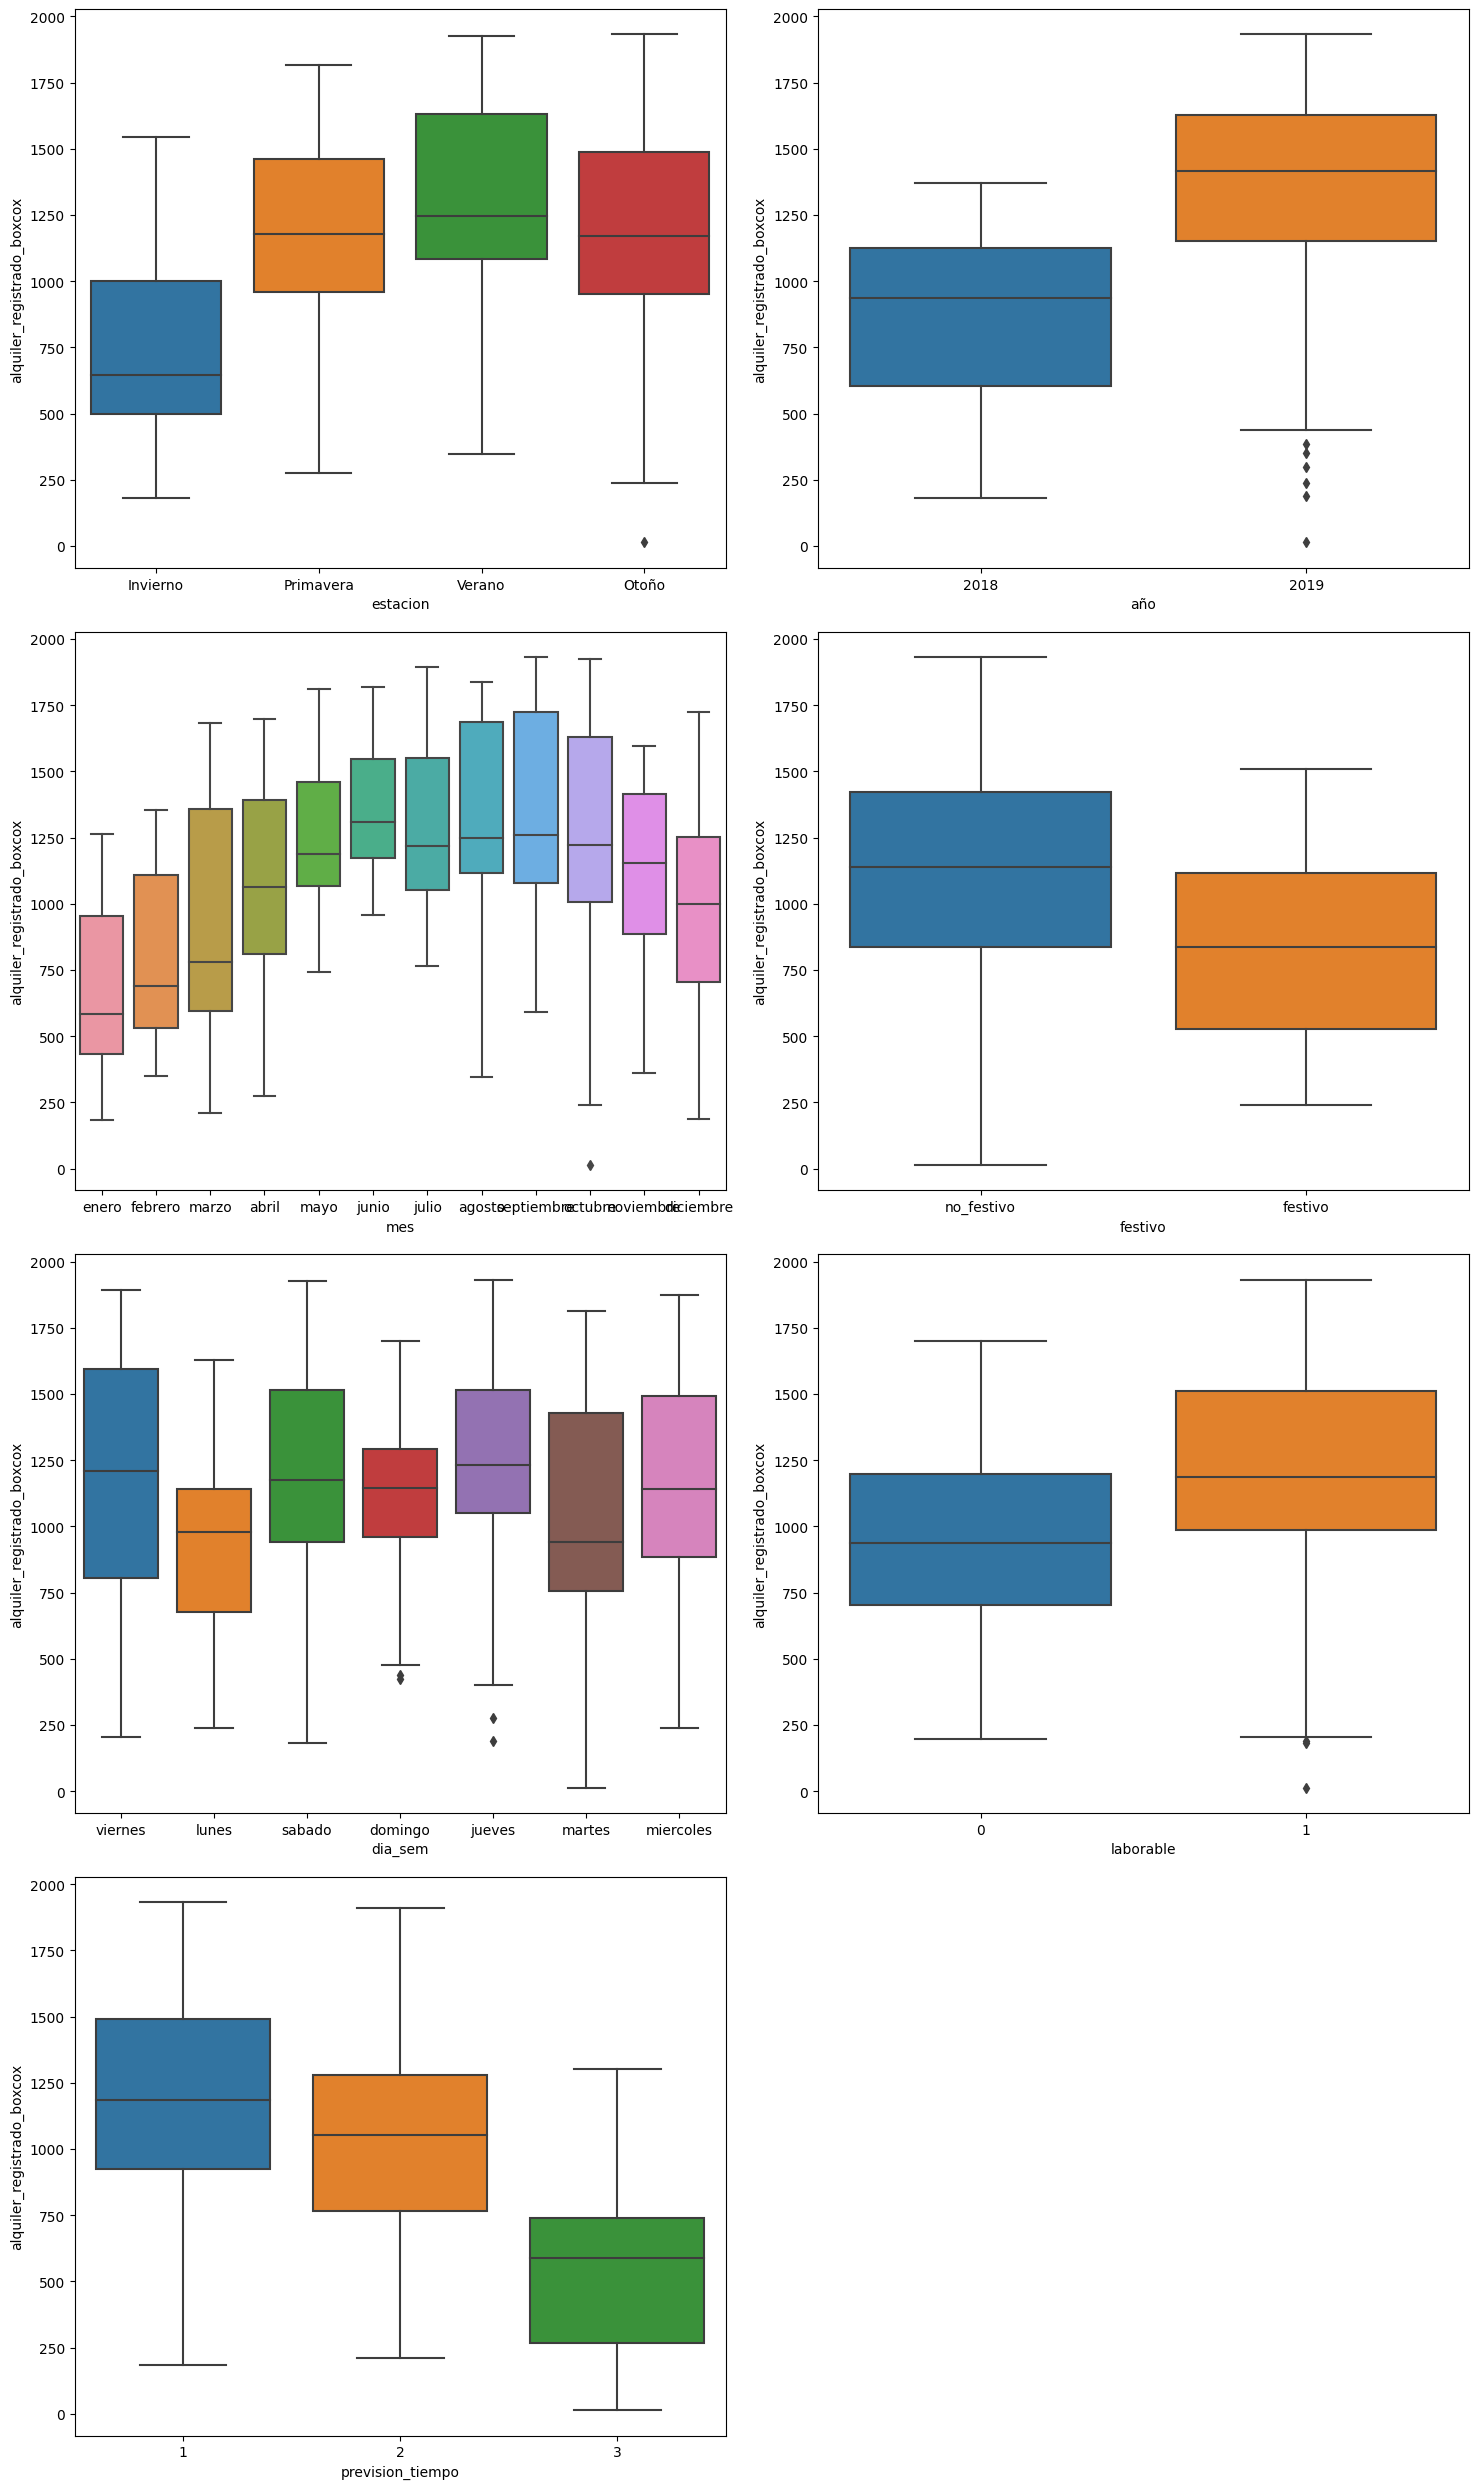

In [18]:
# sacamos boxplots para ver si las variables tienen orden:

fig, axes = plt.subplots(4, 2, figsize=(15, 25))
axes = axes.flat
lista_reg = df_cat.columns
for indice, elemento in enumerate(lista_reg):
    sns.boxplot(x = elemento, y = "alquiler_registrado_boxcox", data = df, ax=axes[indice])
plt.tight_layout()
plt.delaxes(axes[-1])
plt.show();

Orden de las variables: (tomamos como referencia cada 250 puntos = 1 )
 
[{'Invierno': 0, 'Otoño':2, 'Primavera': 2.4, 'Verano': 2.2}, {'2018':0, '2019':2}, {'enero':0, 'febrero':0.5, 'marzo':1,'diciembre': 1.5,'abril': 1.7,'noviembre': 2, ,'mayo': 2.2, 'octubre':2.2, 'abril': 2, 'julio':2.2, 'septiembre':2.5, 'agosto':2.5, 'junio':2.7 },
{'no_festivo': 1, 'festivo':0},
{'miercoles':1, 'jueves':1.3, 'viernes':1.3, 'sabado':1, 'martes':0, 'lunes': 0, 'domingo':1}, {0:0, 1:1}, {3:0, 2:2, 1:2.5}]

In [19]:
#Lo primero que tenemos que hacer es resetear los índices de df, ya que hemos eliminado algunos registros

df = df.reset_index(drop= True)

In [20]:
#creamos los diccionarios con el orden que queremos establecer

[{'Invierno': 0, 'Otoño':2, 'Primavera': 2.4, 'Verano': 2.2}, {'2018':0, '2019':2}, {'enero':0, 'febrero':0.5, 'marzo':1,'diciembre': 1.5,'abril': 1.7,'noviembre': 2, ,'mayo': 2.2, 'octubre':2.2, 'abril': 2, 'julio':2.2, 'septiembre':2.5, 'agosto':2.5, 'junio':2.7 },
{'no_festivo': 1, 'festivo':0},
{'miercoles':1, 'jueves':1.3, 'viernes':1.3, 'sabado':1, 'martes':0, 'lunes': 0, 'domingo':1}, {0:0, 1:1}, {3:0, 2:2, 1:2.5}]
#creamos una lista con las columnas que tienen orden
lista_col = df_cat.columns.drop('festivo')


SyntaxError: invalid syntax (2947825913.py, line 3)

In [ ]:
#Usamos map para codificar las columnas que tienen orden
#creamos un dataframe vacío para ir añadiendo las columnas codificadas
df_enco = pd.DataFrame()

for dic, col in zip(lista_dict, lista_col):   
    
    df_enco[f'{col}_map'] = df[col].map(dic)
    
df_enco.head(2)

,estacion_map,año_map,mes_map,dia_sem_map,laborable_map,prevision_tiempo_map
0,0.0,0.0,0.0,0.5,1,1.5
1,0.0,0.0,0.0,0.5,1,1.5


In [ ]:
for col in df_enco.columns:
    print(df_enco[col].unique())
    print('-------------------------')

[0.  1.4 1.5 1. ]
-------------------------
[0.0, 0.5]
Categories (2, float64): [0.0, 0.5]
-------------------------
[0.  0.5 1.5 2.  2.5 2.7 1. ]
-------------------------
[0.5 0. ]
-------------------------
[1, 0]
Categories (2, int64): [1, 0]
-------------------------
[1.5, 2.0, 0.0]
Categories (3, float64): [2.0, 1.5, 0.0]
-------------------------


In [ ]:
#unimos los dataframes de las variables numéricas estandarizadas con el dataframe de las variables categóricas codificadas

df_estenc_registrado = pd.concat([numericas_robust, df_enco], axis=1)
df_estenc_registrado.head()

,sensacion_termica,humedad,velocidad_viento,alquiler_casual,total_alquileres,alquiler_registrado_boxcox,estacion_map,año_map,mes_map,dia_sem_map,laborable_map,prevision_tiempo_map
0,-0.456399,0.856714,-0.208909,-0.494713,-1.274385,-1.461478,0.0,0.0,0.0,0.5,1,1.5
1,-0.492863,0.332554,0.687550,-0.751041,-1.340188,-1.452214,0.0,0.0,0.0,0.5,1,1.5
2,-1.098990,-0.903573,0.685210,-0.765139,-1.144211,-1.146399,0.0,0.0,0.0,0.0,0,2.0
3,-1.015201,-0.172053,-0.210435,-0.780519,-1.068038,-1.030435,0.0,0.0,0.0,0.0,0,2.0
4,-0.951952,-0.905082,0.060294,-0.813842,-1.054448,-0.998008,0.0,0.0,0.0,0.0,0,2.0


In [ ]:
#guardamos el dataframe

df_estenc_registrado.to_csv('../data/df_estand_encod_registrado.csv')

Decision Tree:

In [ ]:
# dividimos en dos dataframes: x(predictoras) e y (variable respuesta)
# creamos los 4 grupos (train-test)
 
x= df_estenc_registrado.drop("alquiler_registrado_boxcox", axis= 1)
y = df_estenc_registrado["alquiler_registrado_boxcox"]

x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [ ]:
# instanciamos el método y lo ajustamos:

arbol_reg = DecisionTreeRegressor(random_state =0)
arbol_reg.fit(x_train_reg, y_train_reg)

DecisionTreeRegressor(random_state=0)

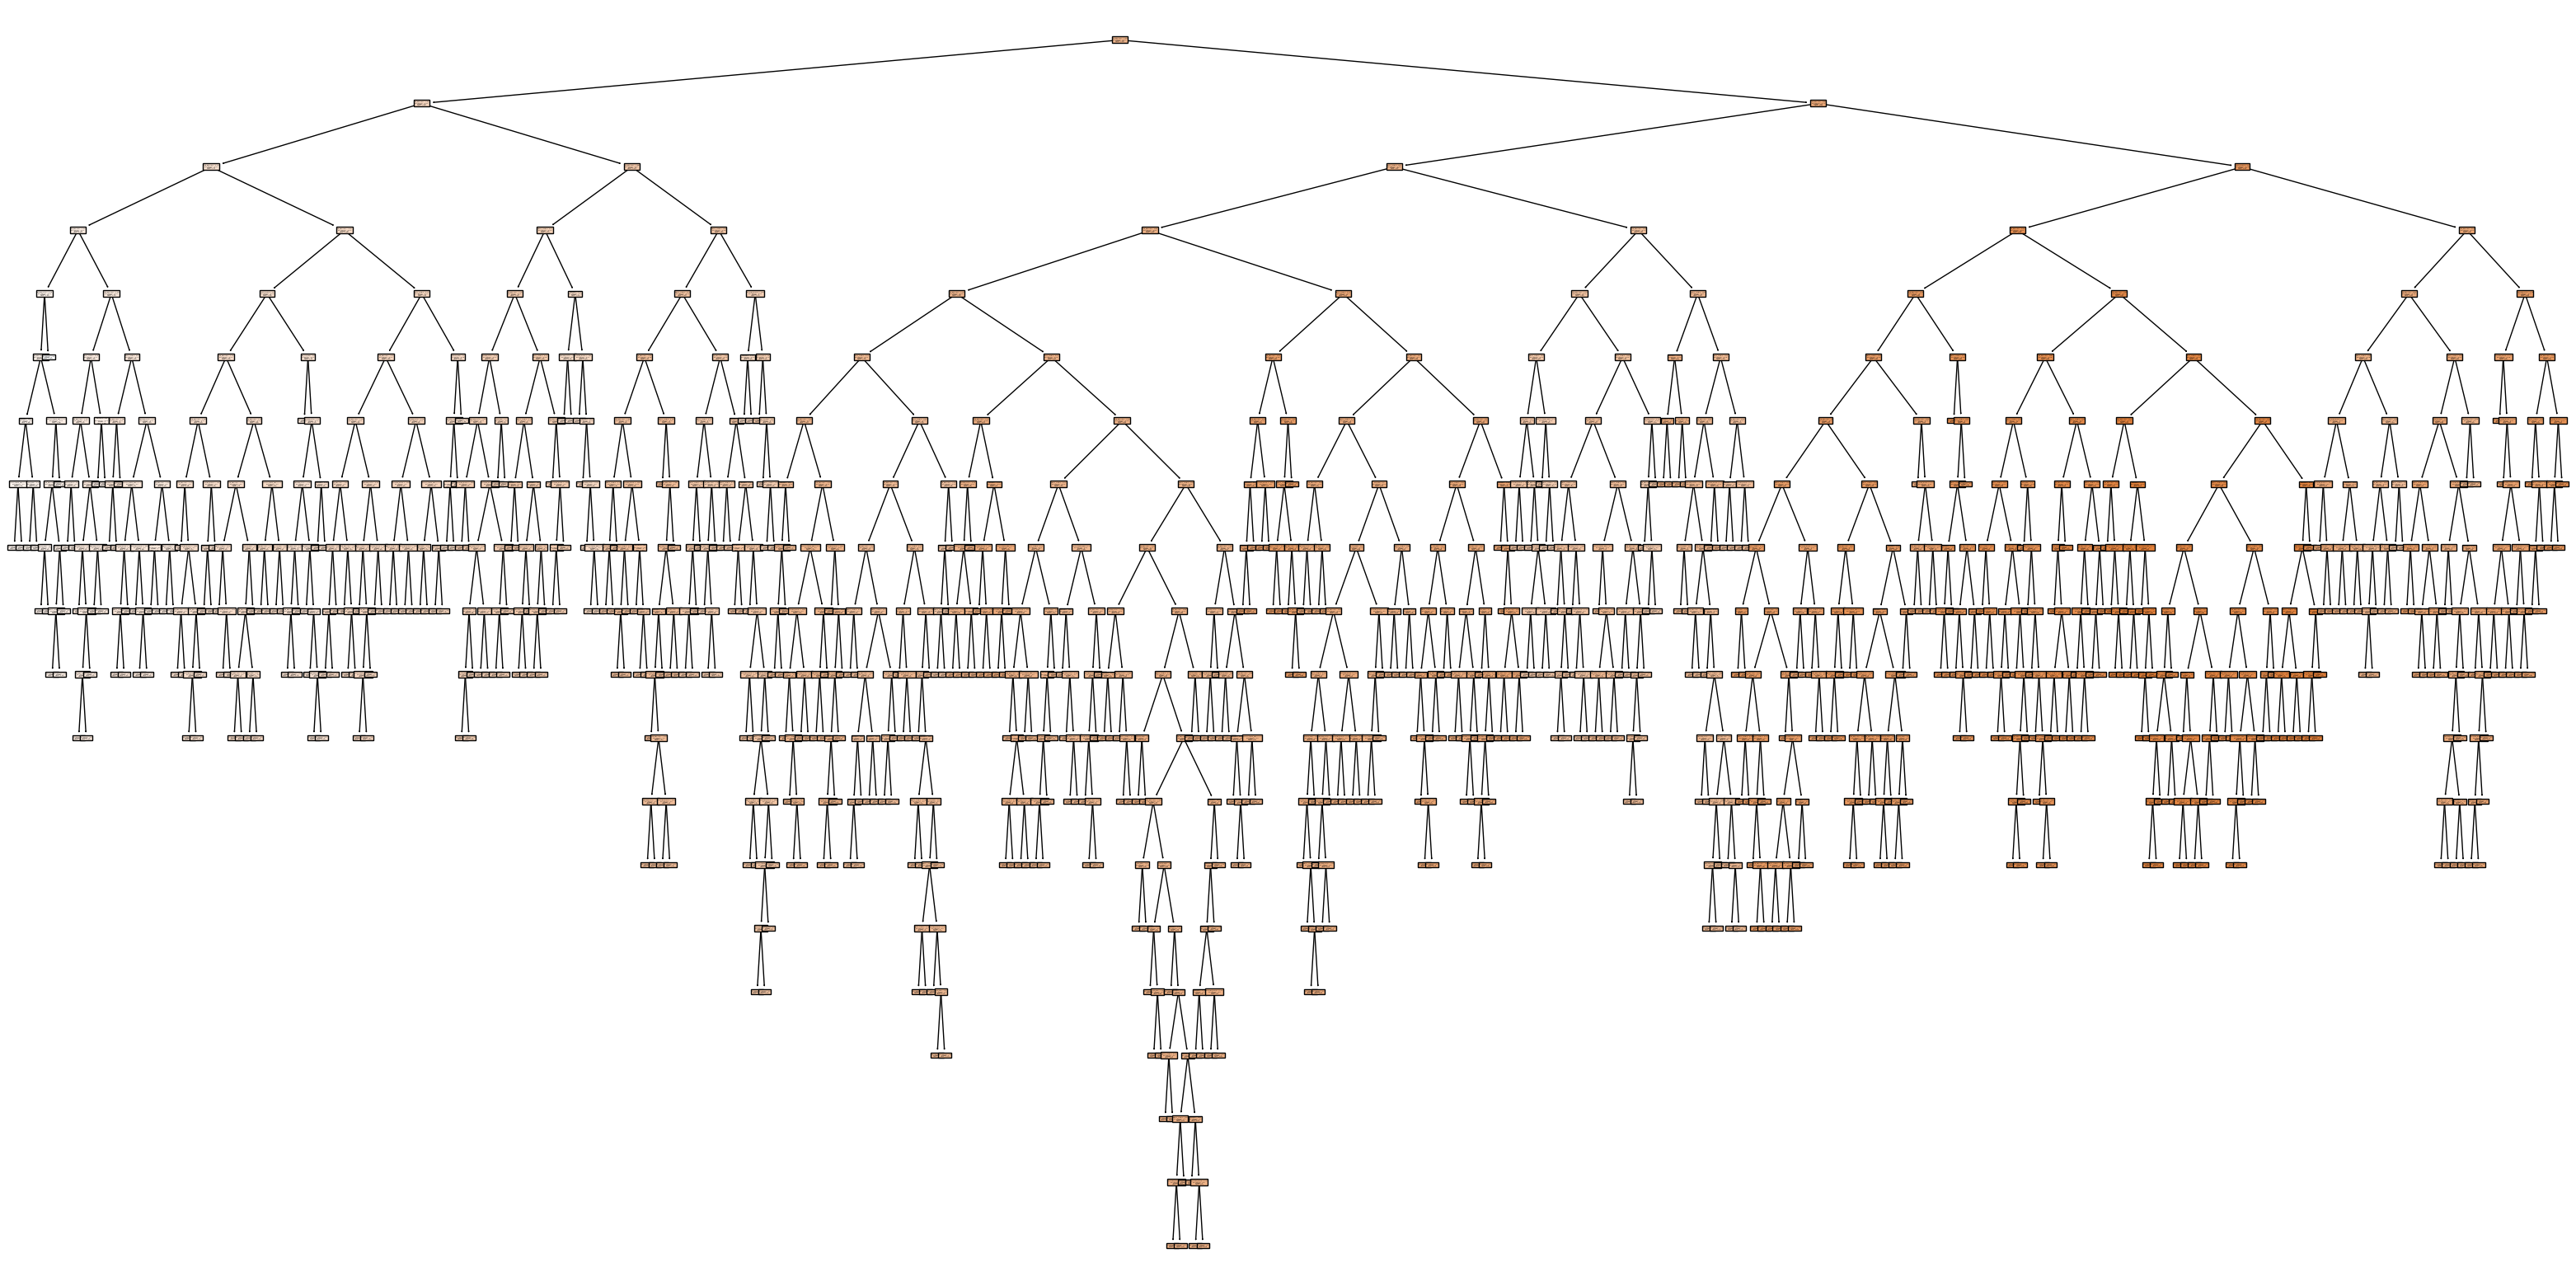

In [ ]:
# imprimimos:

fig = plt.figure(figsize = (40, 20))
tree.plot_tree(arbol_reg, feature_names = list(x_train_reg.columns), filled = True);

In [ ]:
# calculamos la profundidad y la raíz cuadrada de las variables:

print(arbol_reg.tree_.max_depth)
print("___________")
max_features = np.sqrt(len(x_train_reg.columns))
max_features

19
___________


3.3166247903554

In [ ]:
y_pred_test_reg = arbol_reg.predict(x_test_reg)
y_pred_train_reg = arbol_reg.predict(x_train_reg)

In [ ]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    """con esta función calculamos las métricas del árbol

    Args:
        y_test: datos test
        y_train: datos para entrenar
        y_test_pred: datos predichos predictoras (test)
        y_train_pred: datos predichos predictoras (entrenamiento)
        tipo_modelo: nombre que le queremos dar a nuestro modelo

    Returns:
        df: dataframe con las métricas
    """
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [ ]:
arbol_registrado_resultado = metricas(y_test_reg, y_train_reg, y_pred_test_reg, y_pred_train_reg, "DT Registrado I")
arbol_registrado_resultado

,MAE,MSE,RMSE,R2,set,modelo
0,0.060358,0.007065,0.084056,0.983195,test,DT Registrado I
1,0.000000,0.000000,0.000000,1.000000,train,DT Registrado I


In [ ]:
param_reg = {"max_depth": [3,4,5], # tenemos overfitting reducimos la profundidad del modelo, la nuestra anterior era de 19. 
        "max_features": [1,2,3],# ponemos como límite el 4 ya que el resultado de la raiz cuadrada es 3.3
        "min_samples_split": [10,12],
        "min_samples_leaf": [10,12]}

In [ ]:
gs_reg = GridSearchCV(
            estimator=DecisionTreeRegressor(), # tipo de modelo que queremos hacer
            param_grid= param_reg, # hiperparámetros nuevos
            cv=10, # crossvalidation 
            verbose= 0,
            return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error") # la métrica que queremos que nos devuelva

gs_reg.fit(x_train_reg, y_train_reg)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [3, 4, 5], 'max_features': [1, 2, 3],
                         'min_samples_leaf': [10, 12],
                         'min_samples_split': [10, 12]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
mejor_modelo_registrado = gs_reg.best_estimator_
mejor_modelo_registrado

DecisionTreeRegressor(max_depth=5, max_features=3, min_samples_leaf=12,
                      min_samples_split=12)

In [ ]:
y_pred_test_reg_2 = mejor_modelo_registrado.predict(x_test_reg)
y_pred_train_reg_2 = mejor_modelo_registrado.predict(x_train_reg)

arbol_registrado_resultado_2 = metricas(y_test_reg, y_train_reg, y_pred_test_reg_2, y_pred_train_reg_2, "DT Registrado II")
arbol_registrado_resultado_2

,MAE,MSE,RMSE,R2,set,modelo
0,0.306534,0.171069,0.413605,0.593112,test,DT Registrado II
1,0.238253,0.108325,0.329127,0.780019,train,DT Registrado II


In [ ]:
param_reg = {"max_depth": [14,16], 
        "max_features": [2],
        "min_samples_split": [8],
        "min_samples_leaf": [8]}

In [ ]:
gs_reg= GridSearchCV(
            estimator=DecisionTreeRegressor(), # tipo de modelo que queremos hacer
            param_grid= param_reg, # hiperparámetros nuevos
            cv=10, # crossvalidation 
            verbose= 0,
            return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error") # la métrica que queremos que nos devuelva

gs_reg.fit(x_train_reg, y_train_reg)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [14, 16], 'max_features': [2],
                         'min_samples_leaf': [8], 'min_samples_split': [8]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
y_pred_test_reg_3 = mejor_modelo_registrado.predict(x_test_reg)
y_pred_train_reg_3 = mejor_modelo_registrado.predict(x_train_reg)

arbol_registrado_resultado_3 = metricas(y_test_reg, y_train_reg, y_pred_test_reg_3, y_pred_train_reg_3, "DT Registrado III")
arbol_registrado_resultado_3

,MAE,MSE,RMSE,R2,set,modelo
0,0.306534,0.171069,0.413605,0.593112,test,DT Registrado III
1,0.238253,0.108325,0.329127,0.780019,train,DT Registrado III


In [ ]:
dt_resultados_registrado = pd.concat([arbol_registrado_resultado, arbol_registrado_resultado_2, arbol_registrado_resultado_3], axis = 0)
dt_resultados_registrado

,MAE,MSE,RMSE,R2,set,modelo
0,0.060358,0.007065,0.084056,0.983195,test,DT Registrado I
1,0.000000,0.000000,0.000000,1.000000,train,DT Registrado I
0,0.306534,0.171069,0.413605,0.593112,test,DT Registrado II
1,0.238253,0.108325,0.329127,0.780019,train,DT Registrado II
0,0.306534,0.171069,0.413605,0.593112,test,DT Registrado III
1,0.238253,0.108325,0.329127,0.780019,train,DT Registrado III


Creamos un Random Forest:

Como ya tenemos creadas las variables, vamos directamente a crear el bosque

In [ ]:
param_rf_reg = {"max_depth": [11, 12],
        "max_features": [7, 8],
        "min_samples_split": [11, 12],
        "min_samples_leaf": [56, 57],
        "n_estimators": [100]}

gs_rf_reg = GridSearchCV(
            estimator=RandomForestRegressor(n_estimators=100), 
            param_grid= param_rf_reg,
            cv=10,
            verbose=0, 
            return_train_score = True,
            scoring="neg_mean_squared_error") 

gs_rf_reg.fit(x_train_reg, y_train_reg)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [11, 12], 'max_features': [7, 8],
                         'min_samples_leaf': [56, 57],
                         'min_samples_split': [11, 12], 'n_estimators': [100]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
bosque_reg = gs_rf_reg.best_estimator_
bosque_reg

RandomForestRegressor(max_depth=11, max_features=8, min_samples_leaf=56,
                      min_samples_split=11)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


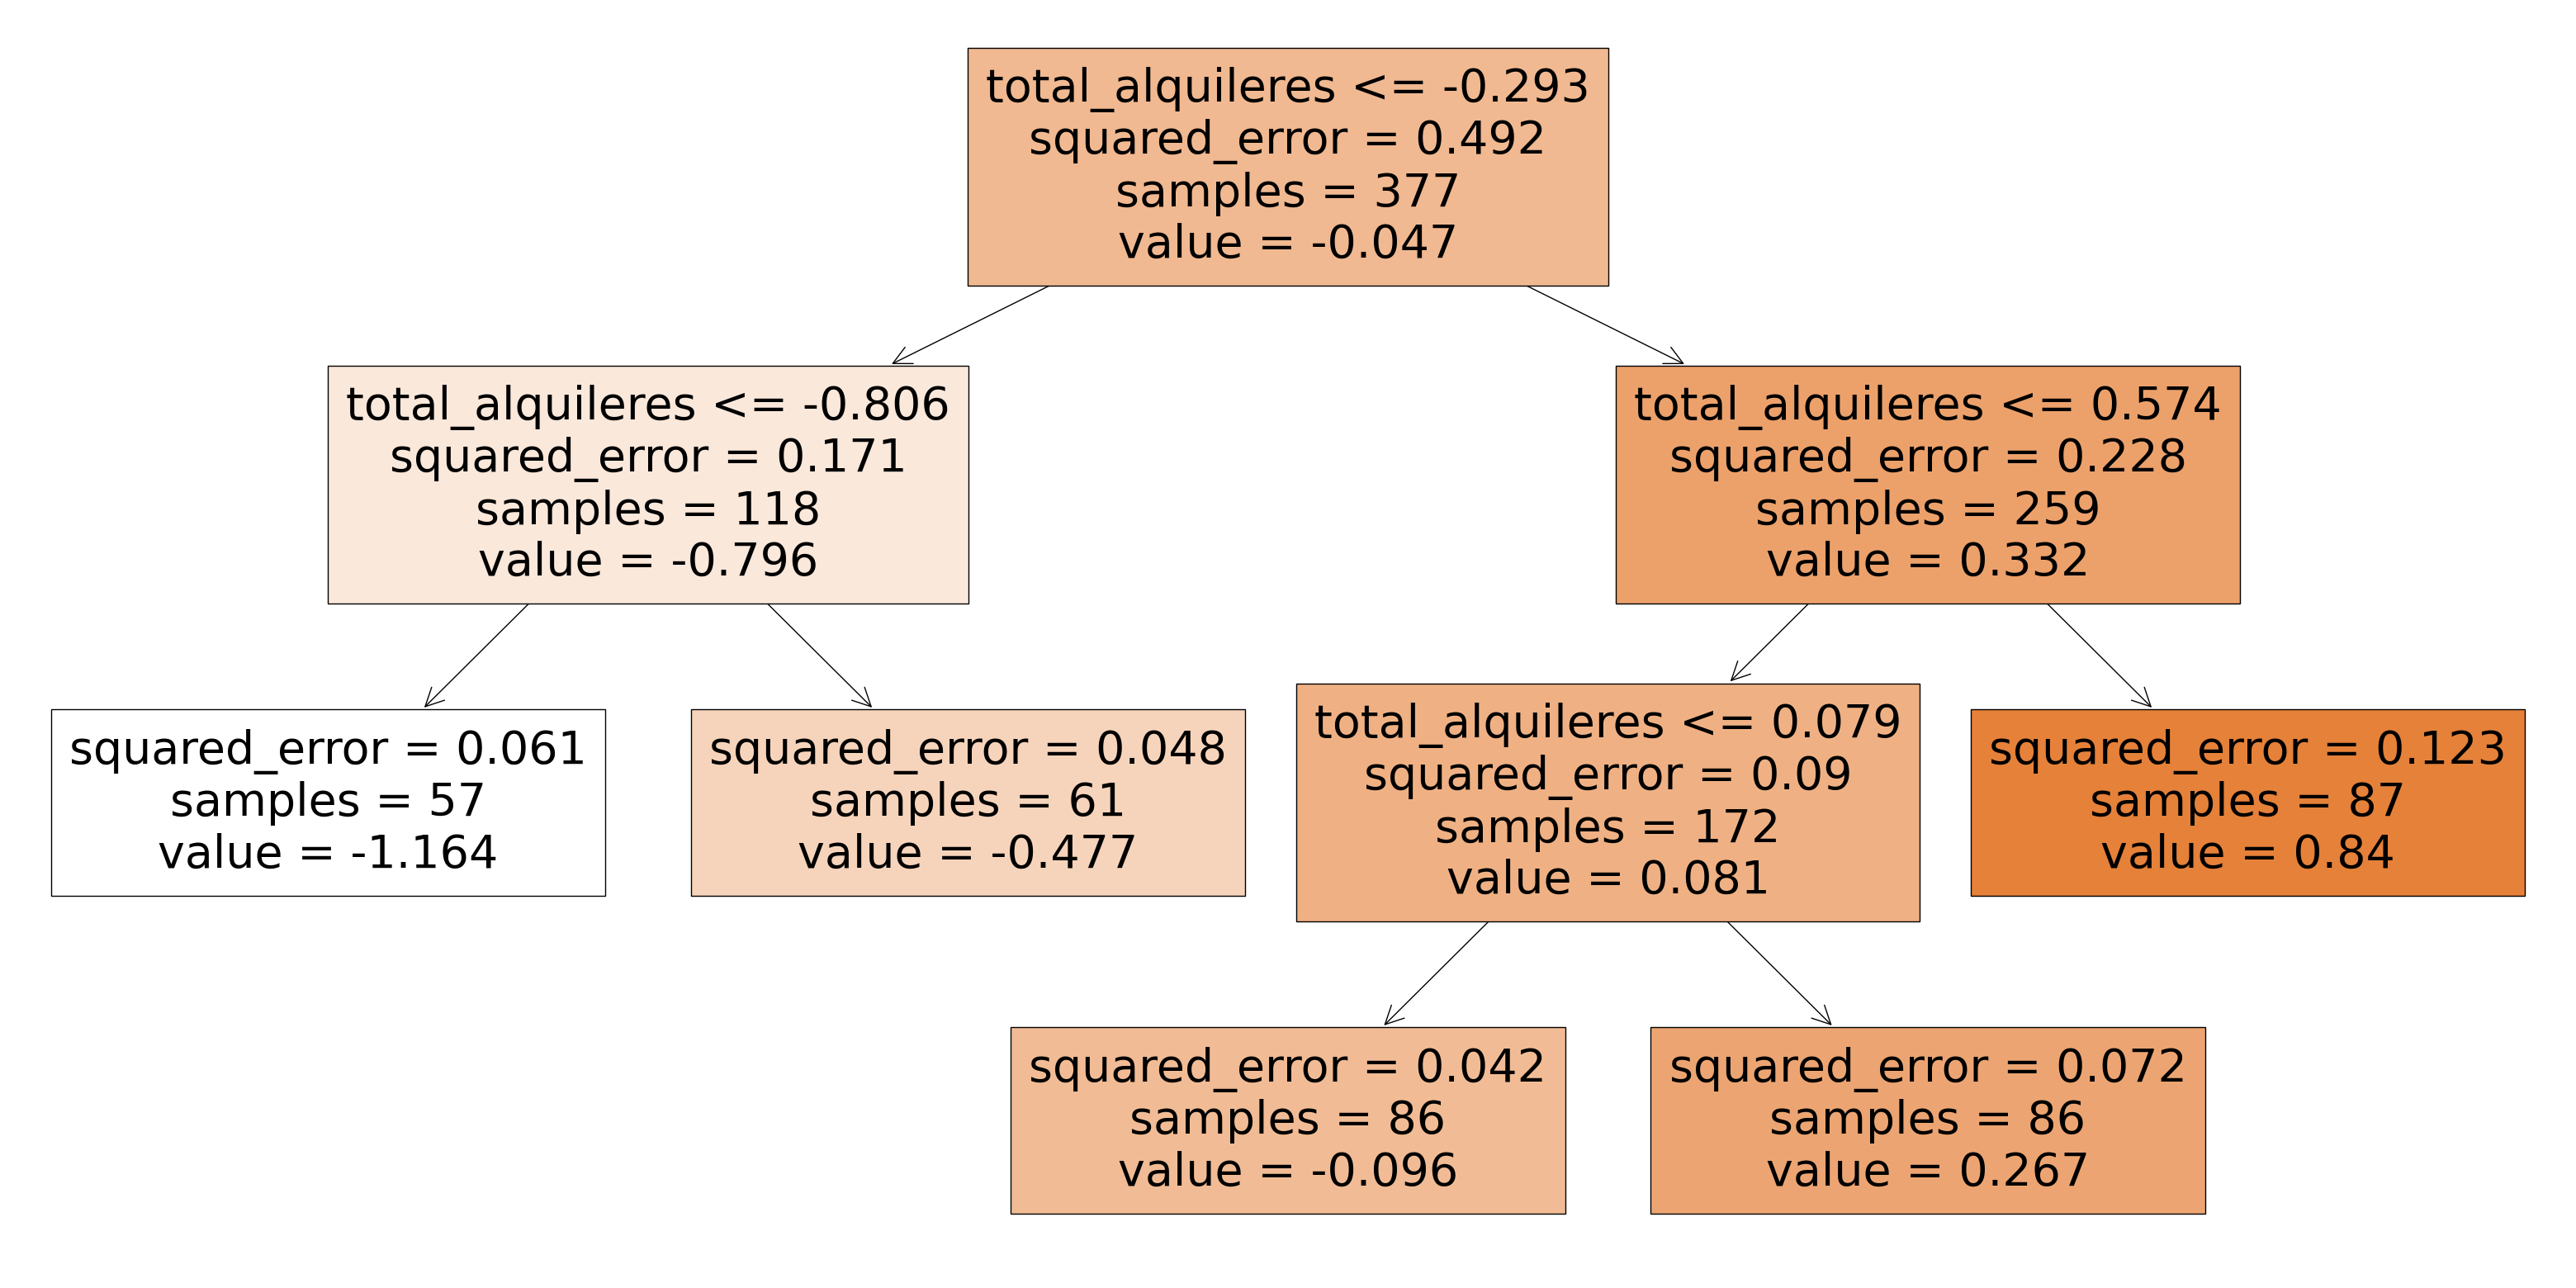

In [ ]:
for arbol in tqdm(bosque_reg):
    fig = plt.figure(figsize=(40, 20))
    tree.plot_tree(arbol, feature_names= list(x_train_reg.columns), filled = True)
    plt.savefig("../graficas/random_forest_registrado.png");
    break

In [ ]:
y_pred_test_rf = bosque_reg.predict(x_test_reg)
y_pred_train_rf = bosque_reg.predict(x_train_reg)

results_forest_reg = metricas(y_test_reg, y_train_reg, y_pred_test_rf, y_pred_train_rf, "RF Registrado I")
results_forest_reg

,MAE,MSE,RMSE,R2,set,modelo
0,0.165619,0.041243,0.203083,0.901904,test,RF Registrado I
1,0.183054,0.054004,0.232388,0.890331,train,RF Registrado I


In [ ]:
param_rf_reg = {"max_depth": [9,10,11,12],
        "max_features": [7,8,9],
        "min_samples_split": [11, 12],
        "min_samples_leaf": [56, 57],
        "n_estimators": [100]}

gs_rf_reg = GridSearchCV(
            estimator=RandomForestRegressor(n_estimators=100), 
            param_grid= param_rf_reg,
            cv=10,
            verbose=0, 
            return_train_score = True,
            scoring="neg_mean_squared_error") 

gs_rf_reg.fit(x_train_reg, y_train_reg)
bosque_reg = gs_rf_reg.best_estimator_
bosque_reg

RandomForestRegressor(max_depth=12, max_features=9, min_samples_leaf=56,
                      min_samples_split=11)

In [ ]:
y_pred_test_rf_2 = bosque_reg.predict(x_test_reg)
y_pred_train_rf_2 = bosque_reg.predict(x_train_reg)

results_forest_reg_2 = metricas(y_test_reg, y_train_reg, y_pred_test_rf_2, y_pred_train_rf_2, "RF Registrado II")
results_forest_reg_2

,MAE,MSE,RMSE,R2,set,modelo
0,0.168891,0.043301,0.208089,0.897008,test,RF Registrado II
1,0.183452,0.053827,0.232006,0.890691,train,RF Registrado II


In [ ]:
param_rf_reg = {"max_depth": [25],
        "max_features": [10],
        "min_samples_split": [11, 12],
        "min_samples_leaf": [56, 57],
        "n_estimators": [100]}

gs_rf_reg = GridSearchCV(
            estimator=RandomForestRegressor(n_estimators=100), 
            param_grid= param_rf_reg,
            cv=10,
            verbose=0, 
            return_train_score = True,
            scoring="neg_mean_squared_error") 

gs_rf_reg.fit(x_train_reg, y_train_reg)
bosque_reg = gs_rf_reg.best_estimator_
bosque_reg

RandomForestRegressor(max_depth=25, max_features=10, min_samples_leaf=56,
                      min_samples_split=11)

In [ ]:
y_pred_test_rf_3 = bosque_reg.predict(x_test_reg)
y_pred_train_rf_3 = bosque_reg.predict(x_train_reg)

results_forest_reg_3 = metricas(y_test_reg, y_train_reg, y_pred_test_rf_3, y_pred_train_rf_3, "RF Registrado III")
results_forest_reg_3

,MAE,MSE,RMSE,R2,set,modelo
0,0.169796,0.045324,0.212894,0.892197,test,RF Registrado III
1,0.183919,0.054642,0.233755,0.889037,train,RF Registrado III


In [ ]:
rf_resultados_registrado = pd.concat([results_forest_reg, results_forest_reg_2, results_forest_reg_3], axis = 0)
rf_resultados_registrado

,MAE,MSE,RMSE,R2,set,modelo
0,0.165619,0.041243,0.203083,0.901904,test,RF Registrado I
1,0.183054,0.054004,0.232388,0.890331,train,RF Registrado I
0,0.168891,0.043301,0.208089,0.897008,test,RF Registrado II
1,0.183452,0.053827,0.232006,0.890691,train,RF Registrado II
0,0.169796,0.045324,0.212894,0.892197,test,RF Registrado III
1,0.183919,0.054642,0.233755,0.889037,train,RF Registrado III


In [ ]:
resultados_alquiler_registrado = pd.concat([dt_resultados_registrado, rf_resultados_registrado], axis= 0)
resultados_alquiler_registrado.to_csv("../data/resultados_alquiler_registrado.csv")

In [ ]:
resultados_alquiler_registrado

,MAE,MSE,RMSE,R2,set,modelo
0,0.060358,0.007065,0.084056,0.983195,test,DT Registrado I
1,0.000000,0.000000,0.000000,1.000000,train,DT Registrado I
0,0.306534,0.171069,0.413605,0.593112,test,DT Registrado II
1,0.238253,0.108325,0.329127,0.780019,train,DT Registrado II
0,0.306534,0.171069,0.413605,0.593112,test,DT Registrado III
1,0.238253,0.108325,0.329127,0.780019,train,DT Registrado III
0,0.165619,0.041243,0.203083,0.901904,test,RF Registrado I
1,0.183054,0.054004,0.232388,0.890331,train,RF Registrado I
0,0.168891,0.043301,0.208089,0.897008,test,RF Registrado II
1,0.183452,0.053827,0.232006,0.890691,train,RF Registrado II


In [ ]:
importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': resultados_alquiler_registrado.feature_importances_}
                            )
# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)
# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

# CONCLUSIONES:

- El primero Decission Tree queda descartado por overfitting.

- Según las pruebas que hemos hecho, tanto el Random forest I como el III serían resultados favorables ya que tienen R2 superiores a 0.7, el test tiene una métricas mayores que el train. En cuanto al resto de métricas, todas son valores bajos.